In [35]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import plot_tree
from scipy.stats import randint

In [2]:
X_train_1 =pd.read_csv("../data/X_train_part1.csv", index_col = "index")
X_train_2 =pd.read_csv("../data/X_train_part2.csv", index_col = "index")
X_train_3 =pd.read_csv("../data/X_train_part3.csv", index_col = "index")
X_train = pd.concat([X_train_1,X_train_2,X_train_3])
y_train = pd.read_csv("../data/y_train.csv", index_col = "index")

X_test =pd.read_csv("../data/X_test.csv", index_col = "index")
y_test = pd.read_csv("../data/y_test.csv", index_col = "index")

X_train_removed = pd.read_csv("../data/X_train_removed.csv",index_col = "index")
X_test_removed = pd.read_csv("../data/X_test_removed.csv",index_col = "index")


In [3]:
# Transfroming 'month' to 'year'

X_train['year'] = pd.to_datetime(X_train['month']).dt.year
X_train_removed['time'] = X_train['month']
X_train = X_train.drop(columns = ['month'])

X_test['year'] = pd.to_datetime(X_test['month']).dt.year
X_test_removed['time'] = X_test['month']
X_test = X_test.drop(columns = ['month'])

# Random forest


In [4]:
regressor = RandomForestRegressor()

regressor.fit(X_train, y_train.values.ravel())

RandomForestRegressor()

In [5]:
# Making prediction
prediction_base_train = regressor.predict(X_train)

## Performance of base model

In [6]:
r2_base_train = r2_score(prediction_base_train, y_train)
print(f'R2 score for base model (Train): {r2_base_train}')

R2 score for base model (Train): 0.9949879618721106


Extremely high. Check for overfitting.

In [7]:
prediction_base_test = regressor.predict(X_test)

r2_base_test = r2_score(prediction_base_test, y_test)

print(f'R2 score for base model (Test): {r2_base_test}')

R2 score for base model (Test): 0.9756344420589644


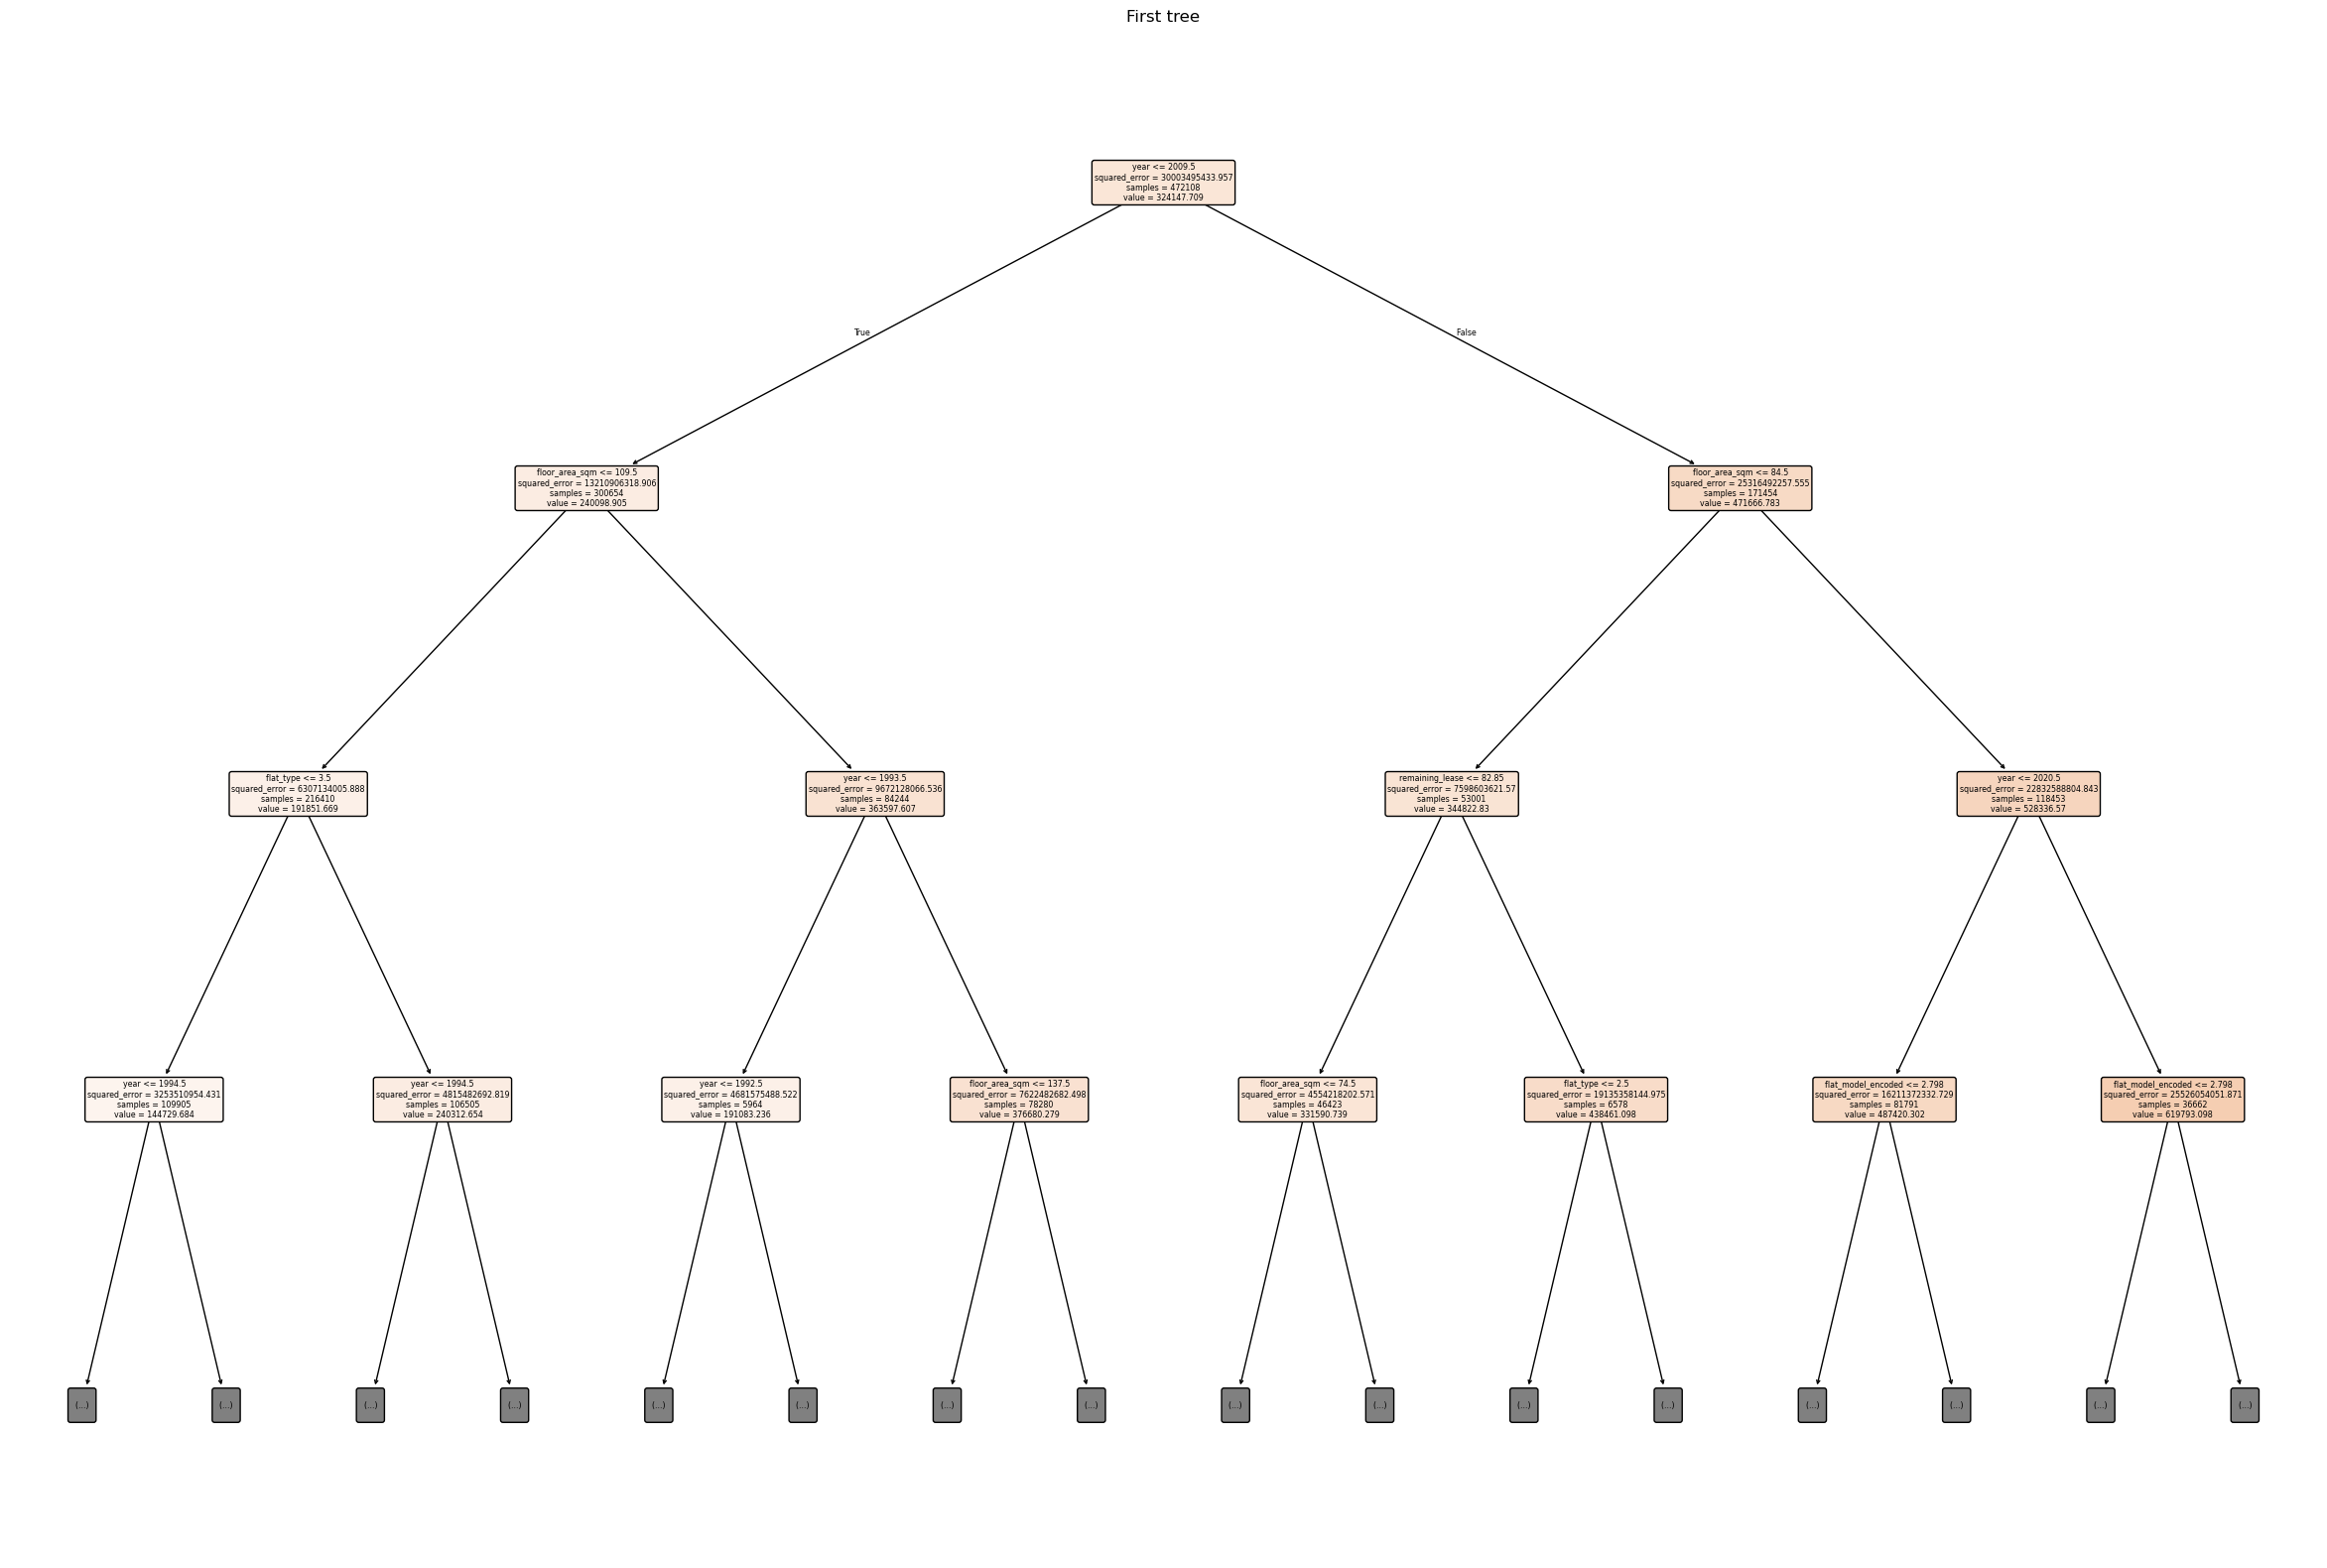

In [8]:
# Code to visulise a particular tree
tree_to_plot = regressor.estimators_[0] # first tree

fig, ax = plt.subplots(figsize = (30,20))
plot_tree(tree_to_plot, feature_names = X_train.columns.tolist(), 
          filled = True, rounded = True, max_depth = 3)
ax.set_title(label = "First tree")
plt.show()

## Checking feature importance

<Axes: >

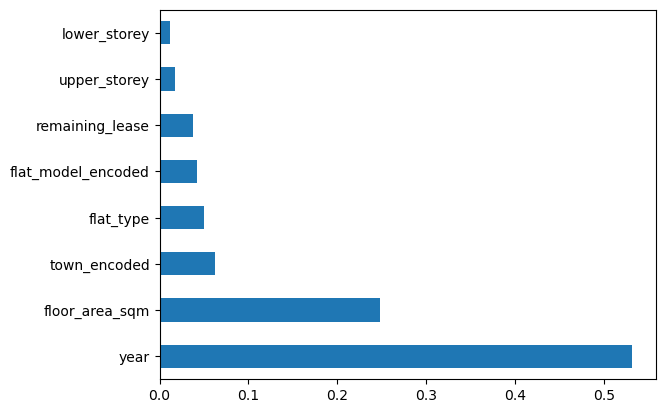

In [9]:
feature_importance = regressor.feature_importances_
features = X_train.columns.tolist()

forest_importance = pd.Series(feature_importance, index = features).sort_values(ascending = False)

forest_importance.head(20).plot(kind = "barh")


Year appears to be the most important factor. However, usual time series analysis is not feasible as there are many other influential features. Try LSTM?

## Hyperparameter tuning and CV

Randomised search is utilised as the sample space can be large and we have a good enough base model already.

In [10]:
params_grid = {
    'n_estimators': randint(50, 300),
    'max_depth': [30, 50, 100, 150, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

random_search = RandomizedSearchCV(
    regressor, param_distributions = params_grid,
    n_iter= 15, scoring = 'r2',
    n_jobs = -1, 
    cv = 5,
    verbose = 1
)

In [11]:
random_search.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/opt/anaconda3/envs/DL/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=15,
                   n_jobs=-1,
                   param_distributions={'max_depth': [30, 50, 100, 150, None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x30cf368d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x30cd38350>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x30cd64050>},
                   scoring='r2', verbose=1)

In [14]:
best_regressor = RandomForestRegressor(max_depth = 50, min_samples_split = 5, n_estimators = 87)

best_regressor.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_depth=50, min_samples_split=5, n_estimators=87)

In [19]:
prediction_test_best = best_regressor.predict(X_test)
r2_best_test = r2_score(prediction_test_best, y_test)
print(f'R2 score for bast RF model (Test): {r2_best_test}')

R2 score for base model (Train): 0.9761875312700854


# Adaboost

In [23]:
ada_regressor1 = AdaBoostRegressor()

ada_regressor1.fit(X_train, y_train.values.ravel())

AdaBoostRegressor()

In [24]:
prediction_ada1_train = ada_regressor1.predict(X_train)
r2_ada1_train = r2_score(prediction_ada1_train, y_train)
print(f'R2 score for base Ada model (Train): {r2_ada1_train}')

R2 score for base Ada model (Train): 0.522473390307026


R2 score is very low. We will try hyperparameter tuning first.

In [ ]:
param_grid_ada = {
    'n_estimators': [50,100,150],
    'learning_rate': [0.01,0.1,1,5,10],
    
}
ada_regressor1 = AdaBoostRegressor(estimator = DecisionTreeRegressor(max_depth = 4))

random_search1 = RandomizedSearchCV(
    ada_regressor1, param_distributions = param_grid_ada,
    n_iter= 5, scoring = 'r2',
    n_jobs = -1, 
    cv = 5,
    verbose = 2
)

random_search1.fit(X_train, y_train.values.ravel())

In [ ]:
ada_regressor2 = AdaBoostRegressor(estimator = DecisionTreeRegressor(max_depth = 5))

random_search2 = RandomizedSearchCV(
    ada_regressor2, param_distributions = param_grid_ada,
    n_iter= 5, scoring = 'r2',
    n_jobs = -1, 
    cv = 5,
    verbose = 2
)

random_search2.fit(X_train, y_train.values.ravel())

In [ ]:
ada_regressor3 = AdaBoostRegressor(estimator = DecisionTreeRegressor(max_depth = 6))

random_search3 = RandomizedSearchCV(
    ada_regressor3, param_distributions = param_grid_ada,
    n_iter= 5, scoring = 'r2',
    n_jobs = -1, 
    cv = 5,
    verbose = 2
)

random_search3.fit(X_train, y_train.values.ravel())

In [41]:
ada1 = random_search1.best_estimator_
ada2 = random_search2.best_estimator_
ada3 = random_search3.best_estimator_

prediction_ada_1 = ada1.predict(X_train)
prediction_ada_2 = ada2.predict(X_train)
prediction_ada_3 = ada3.predict(X_train)

r2_1 = r2_score(prediction_ada_1, y_train)
r2_2 = r2_score(prediction_ada_2, y_train)
r2_3 = r2_score(prediction_ada_3, y_train)

print(f"R2 score for ada1 is {r2_1}")
print(f"R2 score for ada2 is {r2_2}")
print(f"R2 score for ada3 is {r2_3}")

R2 score for ada1 is 0.72907739521922
R2 score for ada2 is 0.7280437649254545
R2 score for ada3 is 0.8504412428868415


It seems that a more complex tree(i.e. higher max_depth) performs better. We will proceed with finding out the optimal tree_depth iteratively.

In [49]:
param_grid_ada = {
    'n_estimators': [50,80,100,120,150],
    'learning_rate': [0.01,0.1,1,5,10],   
}

best = 0
best_ada_regressor = None
for i in range(7, 21):
    base = DecisionTreeRegressor(max_depth = i)
    
    current_ada = AdaBoostRegressor(estimator = base, random_state = 42)
    
    random_search = RandomizedSearchCV(
        current_ada, param_distributions = param_grid_ada,
        n_iter= 10, scoring = 'r2',
        n_jobs = -1, 
        cv = 5,
        verbose = 1, random_state= 42)
    
    random_search.fit(X_train, y_train.values.ravel())
    score = random_search.best_score_
    print(f"Max-depth={i} with R2 score = {score:4f}")
    
    if score > best:
        best = score
        best_ada_regressor = random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/envs/DL/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Max-depth=7 with R2 score = 0.874612
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/envs/DL/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Max-depth=8 with R2 score = 0.889965
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Max-depth=9 with R2 score = 0.915624
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Max-depth=10 with R2 score = 0.936780
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Max-depth=11 with R2 score = 0.950734
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Max-depth=12 with R2 score = 0.958812
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Max-depth=13 with R2 score = 0.964601
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Max-depth=14 with R2 score = 0.967968
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Max-depth=15 with R2 score = 0.970214
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Max-depth=16 with R2 score = 0.971831
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/envs/DL/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Max-depth=17 with R2 score = 0.973043
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/envs/DL/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Max-depth=18 with R2 score = 0.973903
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Max-depth=19 with R2 score = 0.974334
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Max-depth=20 with R2 score = 0.974656


After hitting R2 score > 0.97, the increment is small. Hence, we will adapt max_depth = 20

In [50]:
# see test R2 score

predictions = best_ada_regressor.predict(X_test)
r2_ada_best_test = r2_score(predictions, y_test)

print(f"Best ada model's R2 test score = {r2_ada_best_test}")


Best ada model's R2 test score = 0.974631409029666


Less than Random forest.

# Gradient boosting 